# Modeling fish production, using Stock et al. 2017 equations. 
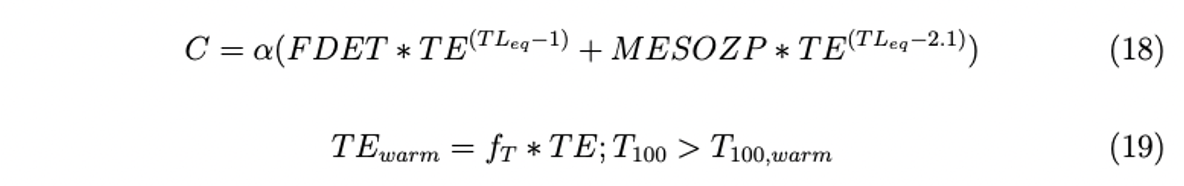

__{$\alpha$}__ = harvesting factor interpreted as the fraction of energy available at TL$_{eq}$ that is realized as catch

* in Stock et al. 2017, single values of TE and $\alpha$  are fit across LMEs such that any interregional variation in these parameters would appear as unexplained catch variance

* __{$\alpha$} was constrained between 0 and 1.__ 

__FDET__ = energy available from the plankton food web via the flux of detritus to sediment 

__TE__ = trophic transfer efficincy, controlling the decay of energy between trophic levels. This is a dimensionless free paramter controlling the decay of energy between trophic levels. 

* __values of TE were constrained within typical observed ranges of 0-0.4__
    * (Pauly D, Christensen V (1995) Primary production required to sustain global fisheries. Nature 374(6519):255–257.)
    * Libralato S, Coll M, Tudela S, Palomera I, Pranovi F (2008) Novel index for quantification of ecosystem effects of fishing as removal of secondary production. Mar Ecol Prog Ser 355:107–129.

__TL$_{eq}$__ = equivalent trophic level of the aggreagte catch derived from FishBase. It scaled by a trophic level of 1 for FDET and 2.1 for MESOZP from the fish catch. 

* Phytoplankton are assigned to trophic level 1, such that TL$_{eq}$ - 1 is the number of trophic steps separating phytoplankton from the fish catch.  

__MESOZP__ = mesozooplankton production not consumed by other zooplankton


In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean
import utils
import re

In [2]:
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=utils.numericalSort)
ds_01= xr.open_mfdataset(files,combine='by_coords')

## Import pelagic and benthic fish production calculated in : `Fish_Productionl_calc.ipnb`

In [3]:
%%time
benthic = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/fish_production_benthic_62yr.npy")
pelagic = np.load("/glade/scratch/gabyn/SPECTRA/GNG595_npy_files/fish_production_pelagic_62yr.npy")

CPU times: user 0 ns, sys: 81.3 ms, total: 81.3 ms
Wall time: 288 ms


In [4]:
ratio = benthic/pelagic

## Ice Fraction

In [5]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [6]:
variables = [f'{var}' for var in ['ECOSYS_IFRAC']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [7]:
%%time

ds_avg = xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_annual = xr.Dataset()

    file = sorted(glob.glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    dsv_annual=xr.open_mfdataset(file, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_annual = xr.merge((ds_annual, dsv_annual[vv]))
        

    ds_annual = ds_annual.drop([v for v in ds_annual.variables if v not in keep_vars]).squeeze()
    ds_annual = ds_annual.mean(dim='time')
    ds_avg = xr.concat([ds_avg, ds_annual],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 9min 32s, sys: 32 s, total: 10min 4s
Wall time: 14min 15s


### High vs Low temperature years

In [8]:
## Bring in Grid information -- /glade/u/home/gabyn/scratch/SPECTRA/GNG595_2ndcycle_1990-2009_clim/
grid_inds = sorted(glob.glob('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_SPECTRA_TAREA.*.nc', recursive=True))
dss= xr.open_mfdataset(grid_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [9]:
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [10]:
temp_ds_inter = np.empty([62,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:] = ds.TEMP[x[i]:x[i]+12,0,:,:]

In [11]:
%matplotlib inline
from glob import glob
import dask
import esmlab
import pop_tools 
from statistics import mean

In [12]:
inter = xr.DataArray(temp_ds_inter, coords={'year':ds_avg.year, 'time':dss.time, 'lat':dss.lat, 'lon':dss.lon},
                      dims=['year', 'time', 'lat', 'lon'])
inter = inter.to_dataset(name='temp_ds_inter')
temp_arctic = esmlab.statistics.weighted_sum(inter.temp_ds_inter[:,:,149:180,:], weights=dss.TAREA[0,149:180,:], dim=['lat', 'lon'])
temp_arctic_anom = temp_arctic-np.nanmean(temp_arctic,axis=0)
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
cold_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) < -(err_ao/2))
warm_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) > (err_ao/2))

In [13]:
cold_years_benthic = np.nanmean(benthic[cold_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
warm_years_benthic = np.nanmean(benthic[warm_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

cold_years_pelagic = np.nanmean(pelagic[cold_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
warm_years_pelagic = np.nanmean(pelagic[warm_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

cold_years_ratio = np.nanmean(ratio[cold_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
warm_years_ratio = np.nanmean(ratio[warm_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

### High vs low Ice Fraction Years 

In [14]:
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [15]:
ECOSYS_IFRAC_ds_inter = np.empty([62,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [16]:
inter['ECOSYS_IFRAC_ds_inter'] = xr.DataArray(ECOSYS_IFRAC_ds_inter, coords={'year':ds_avg.year, 'time':dss.time, 'lat':dss.lat, 'lon':dss.lon},
                      dims=['year', 'time', 'lat', 'lon'])
#inter = inter.to_dataset(name='ECOSYS_IFRAC_ds_inter')
ice_arctic = esmlab.statistics.weighted_sum(inter.ECOSYS_IFRAC_ds_inter[:,:,149:180,:], weights=dss.TAREA[0,149:180,:], dim=['lat', 'lon'])
ice_arctic_anom = ice_arctic-np.nanmean(ice_arctic,axis=0)
err_ao = np.nanstd(ice_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) < -(err_ao/2))
high_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) > (err_ao/2))

In [17]:
low_ice_years_benthic = np.nanmean(benthic[low_ice_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
high_ice_years_benthic = np.nanmean(benthic[high_ice_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

low_ice_years_pelagic = np.nanmean(pelagic[low_ice_years_arctic,:,:],axis=(0,1))# 1/2 standard deviation 
high_ice_years_pelagic = np.nanmean(pelagic[high_ice_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

low_ice_years_ratio = np.nanmean(ratio[low_ice_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
high_ice_years_ratio = np.nanmean(ratio[high_ice_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

### High vs low Nutrient years

In [18]:
NO3_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds= xr.open_mfdataset(NO3_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [19]:
NO3_ds_inter = np.empty([62,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    NO3_ds_inter[i,:,:,:] = ds.NO3[x[i]:x[i]+12,0,:,:]

In [20]:
inter['NO3_ds_inter'] = xr.DataArray(NO3_ds_inter, coords={'year':ds_avg.year, 'time':dss.time, 'lat':dss.lat, 'lon':dss.lon},
                      dims=['year', 'time', 'lat', 'lon'])
#inter = inter.to_dataset(name='NO3_ds_inter')
no3_arctic = esmlab.statistics.weighted_sum(inter.NO3_ds_inter[:,:,149:180,:], weights=dss.TAREA[0,149:180,:], dim=['lat', 'lon'])
no3_arctic_anom = no3_arctic-np.nanmean(no3_arctic,axis=0)
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) < -(err_ao/2))
high_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) > (err_ao/2))

In [21]:
low_no3_years_benthic = np.nanmean(benthic[low_no3_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
high_no3_years_benthic = np.nanmean(benthic[high_no3_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

low_no3_years_pelagic = np.nanmean(pelagic[low_no3_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
high_no3_years_pelagic = np.nanmean(pelagic[high_no3_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

low_no3_years_ratio = np.nanmean(ratio[low_no3_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
high_no3_years_ratio = np.nanmean(ratio[high_no3_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 


## Ice Fraction

In [22]:
ice_frac_annual = np.array(ds_avg.ECOSYS_IFRAC)

In [23]:
## NO3
low_no3_years_ice = ice_frac_annual[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_ice = ice_frac_annual[high_no3_years_arctic,:,:] # 1/2 standard deviation 

## ice
low_ice_years_ice = ice_frac_annual[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_ice = ice_frac_annual[high_ice_years_arctic,:,:] # 1/2 standard deviation 

## temperature
low_temp_years_ice = ice_frac_annual[cold_years_arctic,:,:] # 1/2 standard deviation 
high_temp_years_ice = ice_frac_annual[warm_years_arctic,:,:] # 1/2 standard deviation 

## Benthic vs pelagic fish production

In [24]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [25]:
colorss = colors.LogNorm(vmin=0.01, vmax=10)

In [26]:
both = benthic+pelagic

cold_years_both = np.nanmean(both[cold_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
warm_years_both = np.nanmean(both[warm_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

low_ice_years_both = np.nanmean(both[low_ice_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
high_ice_years_both = np.nanmean(both[high_ice_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

low_no3_years_both = np.nanmean(both[low_no3_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 
high_no3_years_both = np.nanmean(both[high_no3_years_arctic,:,:],axis=(0,1)) # 1/2 standard deviation 

## Save the benthic and pelagic portions of fish production on an nc file: 

## 1. Save 
    - fish_production = xr.DataArray(benthic, coords={'time':time,'TLAT':ds_01.TLAT,  'TLONG':ds_01.TLONG},
                                               dims=['time', 'nlat', 'nlon'])
    - fish_production = fish_production.to_dataset(name='benthic')
    - fish_production['pelagic'] = xr.DataArray(pelagic, coords={'time':time,'TLAT':ds_01.TLAT,'TLONG':ds_01.TLONG},
                                               dims=['time', 'nlat', 'nlon'])
                                               

    - fish_production.to_netcdf('/glade/u/home/gabyn/scratch/SPECTRA/nc_files/fish_production.nc');
    
## 2. Regrid from that nc file (you can do this in bash)
BENTHIC 

    * cd /glade/u/home/gabyn/scratch/SPECTRA/nc_files'
    * ncatted -a coordinates,benthic,c,c,"TLONG TLAT" fish_production.nc
    * cdo remapbil,r360x180 -selname,benthic fish_production.nc fish_production_benthic.nc
    * cdo sellonlatbox,-180,180,-89.5,89.5 fish_production_benthic.nc regrid_fish_production_benthic.nc

PELAGIC 

    * ncatted -a coordinates,pelagic,c,c,"TLONG TLAT" fish_production.nc
    * cdo remapbil,r360x180 -selname,pelagic fish_production.nc fish_production_pelagic.nc
    * cdo sellonlatbox,-180,180,-89.5,89.5 fish_production_pelagic.nc regrid_fish_production_pelagic.nc

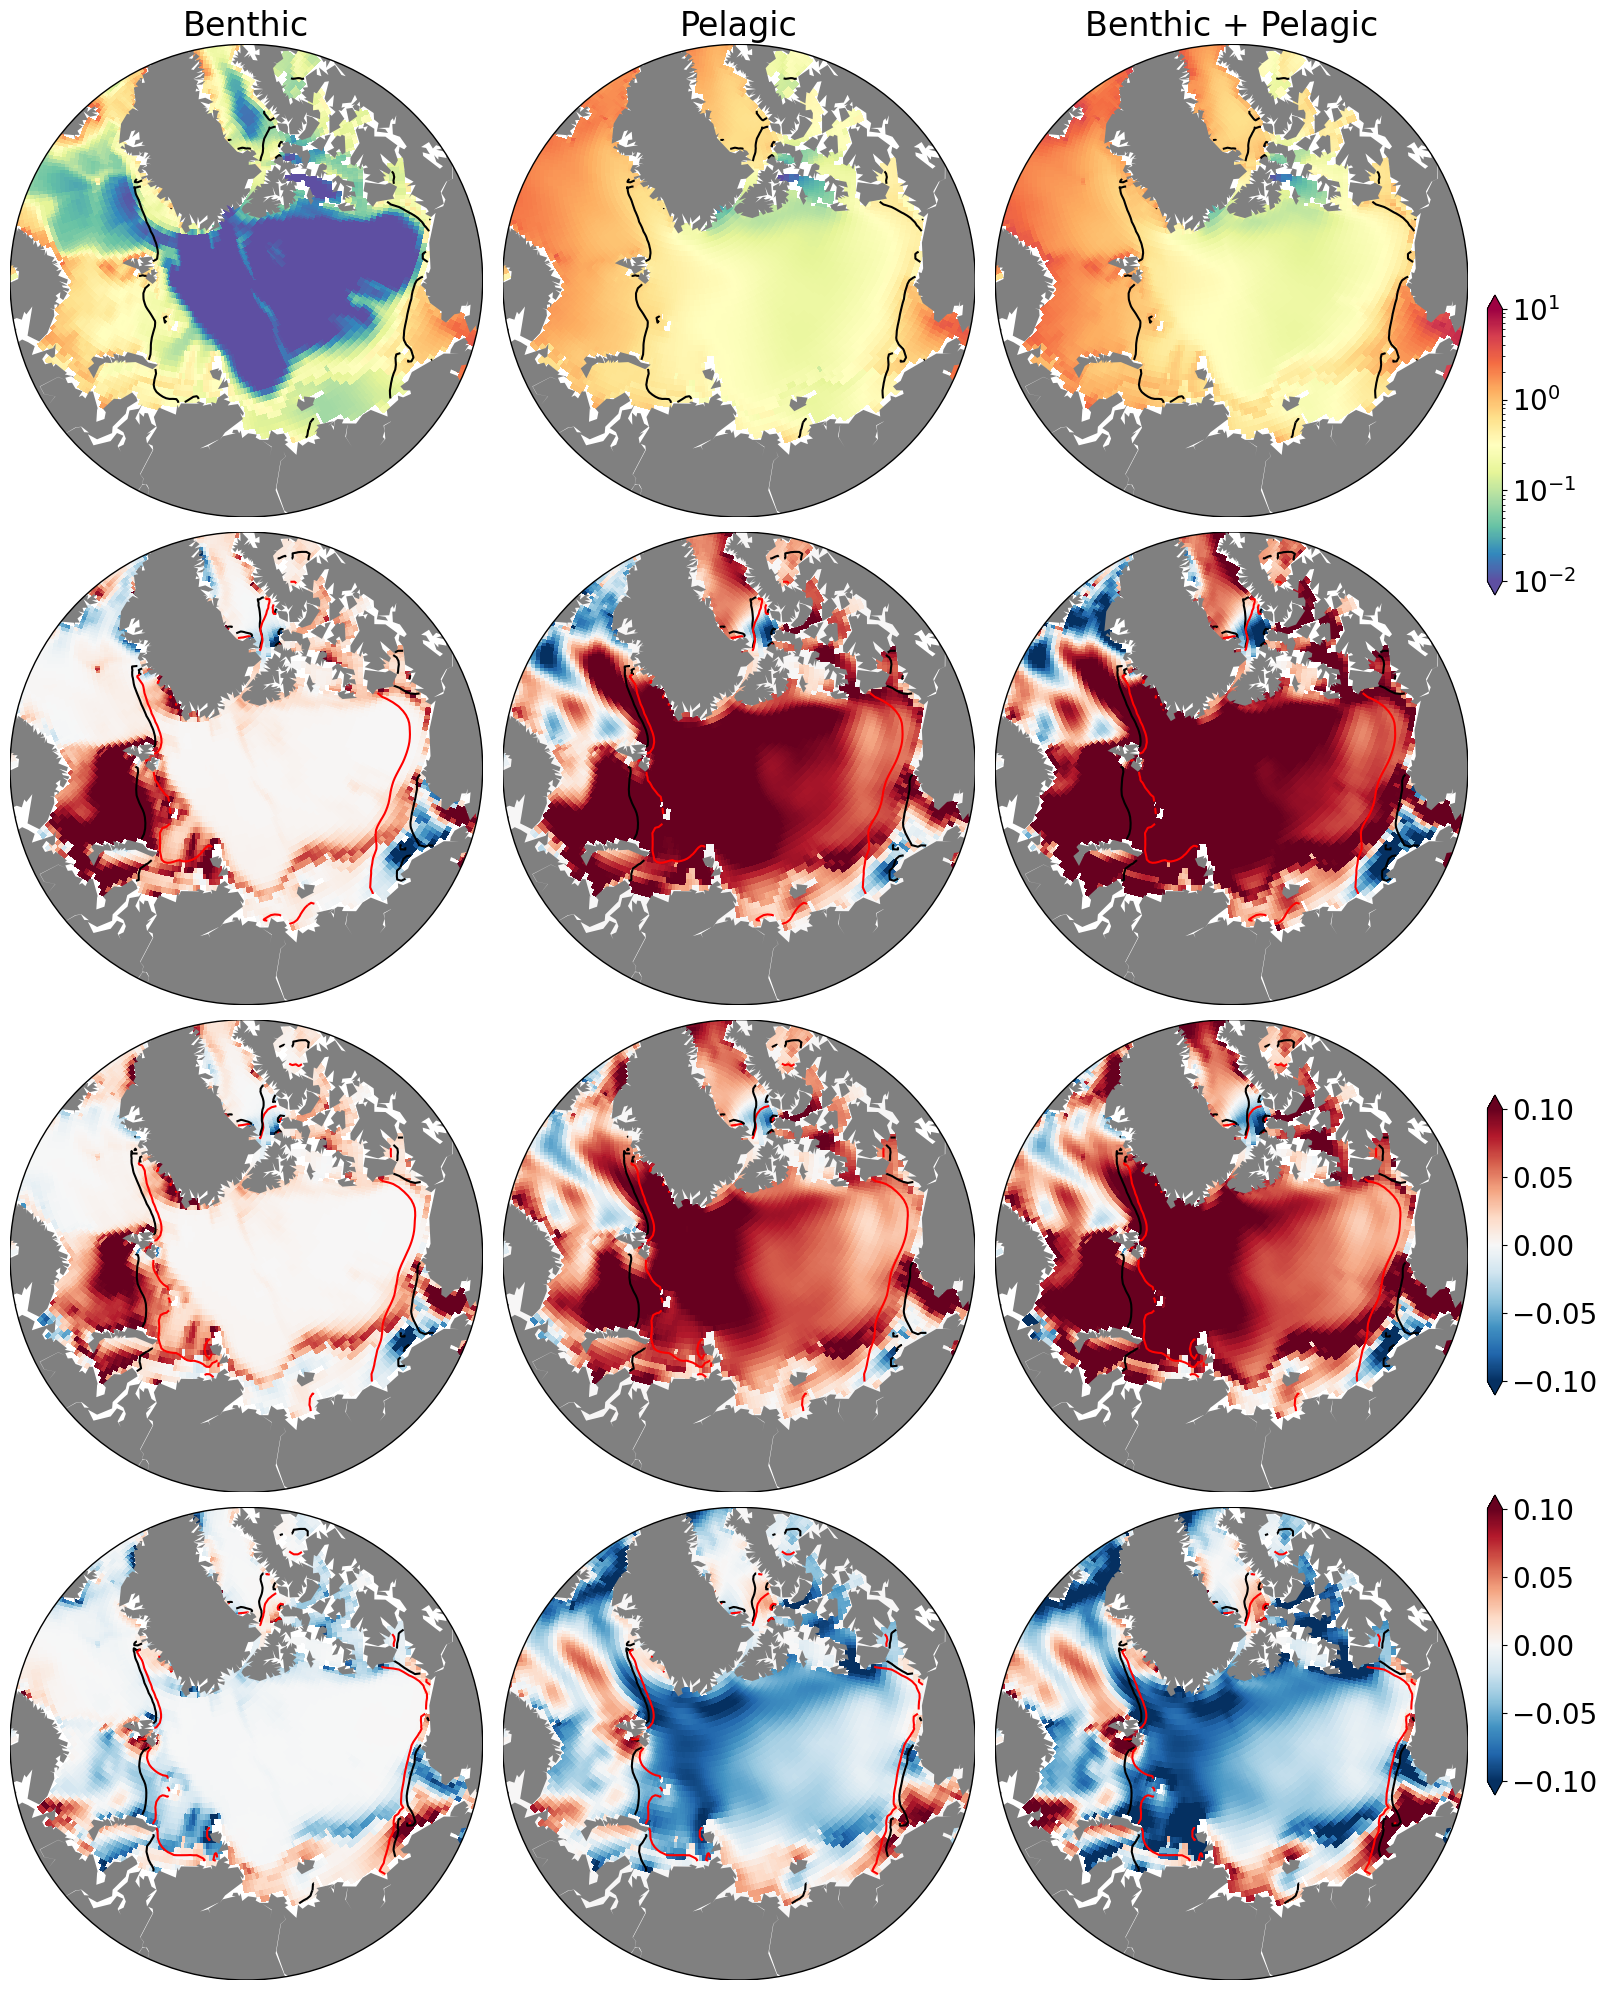

In [27]:
from mpl_toolkits.basemap import Basemap
fig = plt.figure(figsize=(15, 20))

#### 62 year average!!! 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 3, 1)
lon, lat, ben = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(benthic,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, ben, cmap='Spectral_r',norm=colorss);
tlon, tlat, benthic_ice = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(ds_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, benthic_ice,levels = [0.7],colors='k');
ax.set_title('Benthic', fontsize =24)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(4, 3, 2)
lon, lat, pel = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(pelagic,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, pel, cmap='Spectral_r',norm=colorss);
tlon, tlat, pelagic_ice = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(ds_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, pelagic_ice,levels = [0.7],colors='k');
ax.set_title('Pelagic', fontsize =24)
cbar_ax = fig.add_axes([0.999, 0.7, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 3, 3)
lon, lat, bot = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(both,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
lev = np.arange(-2.0, 2.1, 0.5)
#norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0)
cf = m.pcolor(x, y, bot,cmap='Spectral_r',norm=colorss);
tlon, tlat, ratio_ice = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(ds_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, ratio_ice,levels = [0.7],colors='k');
ax.set_title('Benthic + Pelagic', fontsize=24)
#cbar_ax = fig.add_axes([0.999, 0.5, 0.01, 0.15])
#cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.set_ticks([-2,-1,0,1,2])
#cb.ax.tick_params(labelsize=20)
#cb.ax.set_title('Benthic/Pelagic', fontsize=24)

########## Differences!!! 
vminn=-0.1
vmaxx=0.1                                
# Benthic 
# cold-warm/warm years. 
ax = fig.add_subplot(4, 3, 7)
b_temp_diff = warm_years_benthic-cold_years_benthic
lon, lat, b_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, b_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, b_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_temp_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_temp_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# Pelagic 
# cold-warm/warm years. 
ax = fig.add_subplot(4, 3, 8)
p_temp_diff = warm_years_pelagic-cold_years_pelagic
lon, lat, p_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, p_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, p_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_temp_years_ice,axis=(0,1)))
tlon, tlat, ice_high =adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_temp_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); 


# ratio 
# cold-warm/warm years. 
ax = fig.add_subplot(4, 3, 9)
r_temp_diff = warm_years_both-cold_years_both
lon, lat, r_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, r_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, r_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_temp_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_temp_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); 

## Ice Fraction

# Benthic 
# high-low/low years. 
ax = fig.add_subplot(4, 3, 4)
b_ice_diff = ((low_ice_years_benthic-high_ice_years_benthic))
lon, lat, b_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, b_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, b_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_ice_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_ice_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 

# Pelagic 
# high-low/low years. 
ax = fig.add_subplot(4, 3, 5)
p_ice_diff = ((low_ice_years_pelagic-high_ice_years_pelagic))
lon, lat, p_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, p_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, p_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_ice_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_ice_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 

# Ratio 
# high-low/low years.
ax = fig.add_subplot(4, 3, 6)
r_ice_diff = low_ice_years_both-high_ice_years_both
lon, lat, r_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, r_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, r_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_ice_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_ice_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 


# Benthic 
# high-low/high years NO3
ax = fig.add_subplot(4, 3, 10)
b_no3_diff = ((high_no3_years_benthic-low_no3_years_benthic))
lon, lat, b_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, b_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, b_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_no3_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_no3_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 

# Pelagic 
# high-low/high years NO3
ax = fig.add_subplot(4, 3, 11)
p_no3_diff = ((high_no3_years_pelagic-low_no3_years_pelagic))
lon, lat, p_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, p_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, p_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_no3_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_no3_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

# Ratio 
# high-low/high years NO3
ax = fig.add_subplot(4, 3, 12)
r_no3_diff = high_no3_years_both-low_no3_years_both
lon, lat, r_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, r_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, r_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_no3_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_no3_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 
cbar_ax = fig.add_axes([0.999, 0.1, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
fig.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/fish_production_AO_TLeq3_diff_interannual_Benthic_Pealgic_both.png',dpi=600, bbox_inches='tight')

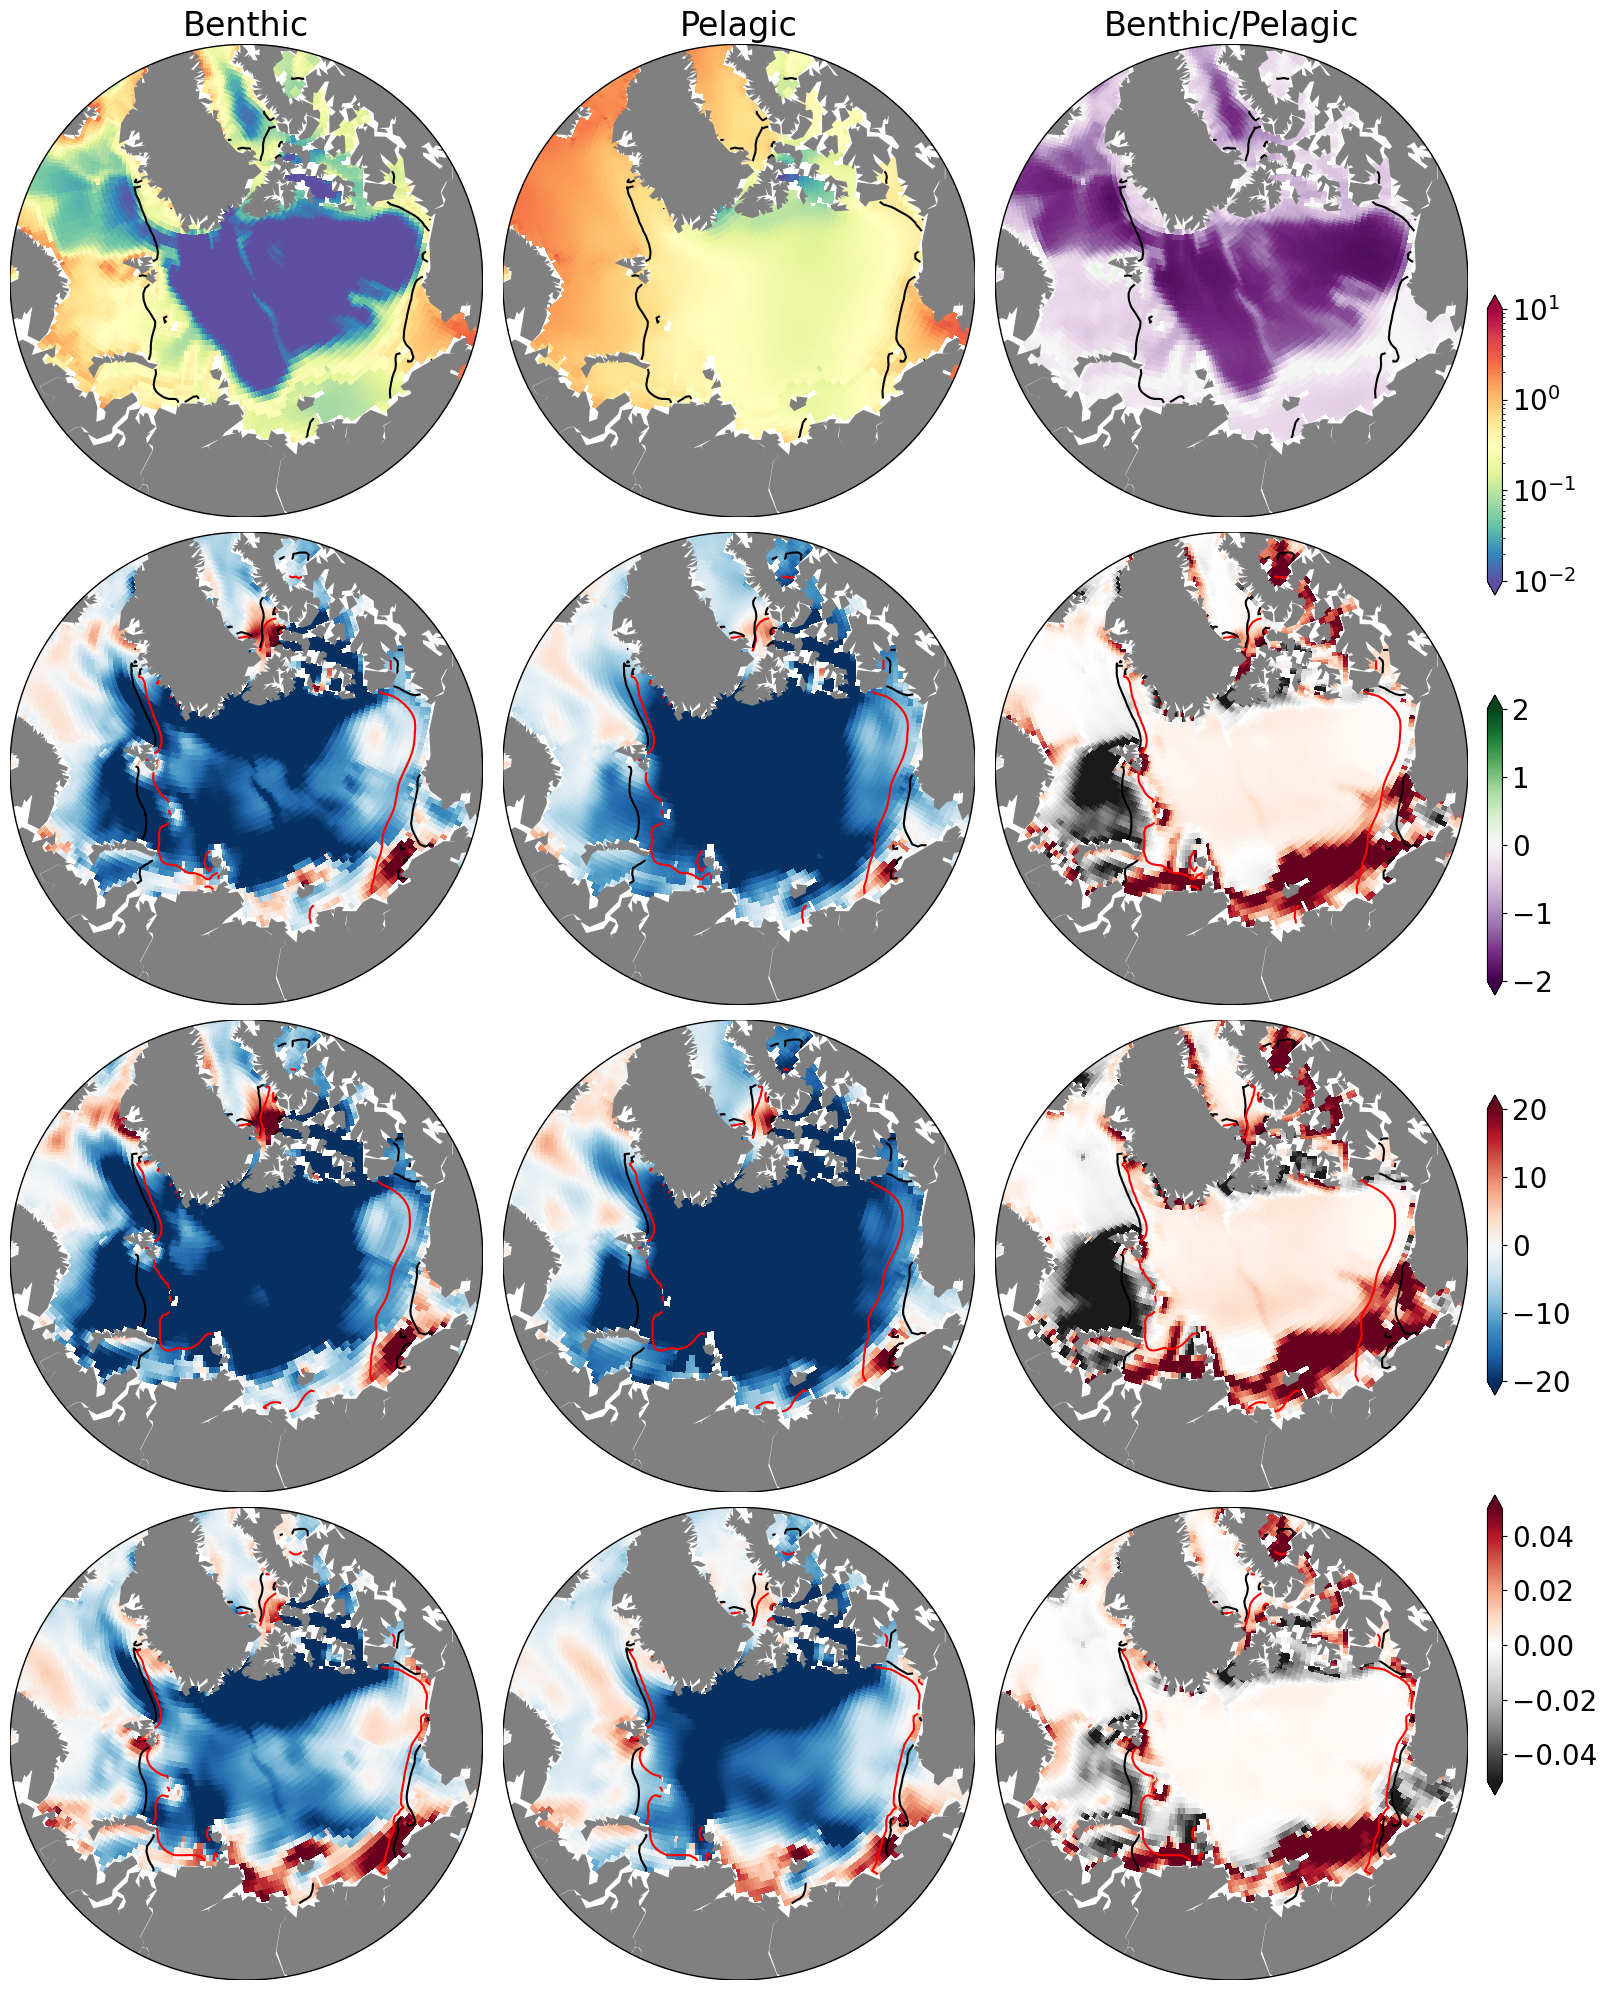

In [62]:
from mpl_toolkits.basemap import Basemap
##lev = np.arange(0, 1, 0.01)
#norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(15, 20))

#### 62 year average!!! 

# Winter TLeq = 3 (62yr average)
ax = fig.add_subplot(4, 3, 1)
lon, lat, ben = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(benthic,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, ben, cmap='Spectral_r',norm=colorss);
tlon, tlat, benthic_ice = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(ds_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, benthic_ice,levels = [0.7],colors='k');
ax.set_title('Benthic', fontsize =24)

# Spring TLeq = 3, (62yr average)
ax = fig.add_subplot(4, 3, 2)
lon, lat, pel = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(pelagic,axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, pel, cmap='Spectral_r',norm=colorss);
tlon, tlat, pelagic_ice = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(ds_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, pelagic_ice,levels = [0.7],colors='k');
ax.set_title('Pelagic', fontsize =24)
cbar_ax = fig.add_axes([0.999, 0.7, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

# Summer TLeq = 3, (62 yr average)
ax = fig.add_subplot(4, 3, 3)
lon, lat, rat = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.log10(np.nanmean(benthic,axis=0)/np.nanmean(pelagic,axis=0)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
lev = np.arange(-2.0, 2.1, 0.5)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0)
cf = m.pcolor(x, y, rat, cmap='PRGn',norm=norm);
tlon, tlat, ratio_ice = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(ds_avg.ECOSYS_IFRAC, axis=0))
cs = m.contour(x, y, ratio_ice,levels = [0.7],colors='k');
ax.set_title('Benthic/Pelagic', fontsize=24)
cbar_ax = fig.add_axes([0.999, 0.5, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.set_ticks([-2,-1,0,1,2])
cb.ax.tick_params(labelsize=20)
#cb.ax.set_title('Benthic/Pelagic', fontsize=24)

########## Differences!!! 

# Benthic 
# cold-warm/warm years. 
ax = fig.add_subplot(4, 3, 4)
b_temp_diff = ((cold_years_benthic-warm_years_benthic)/warm_years_benthic)*100
lon, lat, b_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, b_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, b_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_temp_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_temp_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 


# Pelagic 
# cold-warm/warm years. 
ax = fig.add_subplot(4, 3, 5)
p_temp_diff = ((cold_years_pelagic-warm_years_pelagic)/warm_years_pelagic)*100
lon, lat, p_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, p_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, p_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_temp_years_ice,axis=(0,1)))
tlon, tlat, ice_high =adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_temp_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); 


# ratio 
# cold-warm/warm years. 
ax = fig.add_subplot(4, 3, 6)
r_temp_diff = cold_years_ratio-warm_years_ratio
lon, lat, r_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, r_temp_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, r_diff, cmap='RdGy_r',vmin=-0.05,vmax=0.05);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_temp_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_temp_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='red'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='k'); 

## Ice Fraction

# Benthic 
# high-low/low years. 
ax = fig.add_subplot(4, 3, 7)
b_ice_diff = ((high_ice_years_benthic-low_ice_years_benthic)/ low_ice_years_benthic)*100
lon, lat, b_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, b_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, b_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_ice_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_ice_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 

# Pelagic 
# high-low/low years. 
ax = fig.add_subplot(4, 3, 8)
p_ice_diff = ((high_ice_years_pelagic-low_ice_years_pelagic)/ low_ice_years_pelagic)*100
lon, lat, p_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, p_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, p_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_ice_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_ice_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 

# Ratio 
# high-low/low years.
ax = fig.add_subplot(4, 3, 9)
r_ice_diff = high_ice_years_ratio-low_ice_years_ratio
lon, lat, r_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, r_ice_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, r_diff, cmap='RdGy_r',vmin=-0.05,vmax=0.05);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_ice_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_ice_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 


# Benthic 
# high-low/high years NO3
ax = fig.add_subplot(4, 3, 10)
b_no3_diff = ((high_no3_years_benthic-low_no3_years_benthic)/ low_no3_years_benthic)*100
lon, lat, b_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, b_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, b_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_no3_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_no3_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 

# Pelagic 
# high-low/high years NO3
ax = fig.add_subplot(4, 3, 11)
p_no3_diff = ((high_no3_years_pelagic-low_no3_years_pelagic)/ low_no3_years_pelagic)*100
lon, lat, p_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, p_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, p_diff, cmap='RdBu_r',vmin=-20,vmax=20);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_no3_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_no3_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 
cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

# Ratio 
# high-low/high years NO3
ax = fig.add_subplot(4, 3, 12)
r_no3_diff = high_no3_years_ratio-low_no3_years_ratio
lon, lat, r_diff = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, r_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, r_diff, cmap='RdGy_r',vmin=-0.05,vmax=0.05);
tlon, tlat, ice_low = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(low_no3_years_ice,axis=(0,1)))
tlon, tlat, ice_high = adjust_pop_grid(ds_01.TLONG, ds_01.TLAT, np.nanmean(high_no3_years_ice,axis=(0,1)))
cs = m.contour(x, y, ice_high,levels = [0.7],colors='k'); 
css = m.contour(x, y, ice_low,levels = [0.7],colors='red'); 
cbar_ax = fig.add_axes([0.999, 0.1, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
fig.tight_layout()

#fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/fish_production_AO_TLeq3_diff_interannual.png',dpi=600, bbox_inches='tight')

In [63]:
fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/fish_production_AO_TLeq3_diff_interannual_final.png',dpi=600, bbox_inches='tight')